In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from PIL import Image
# Transform RGB array to Lab array
from skimage.color import rgb2lab, lab2rgb
# Transform RGB to HSV
from skimage.color import rgb2hsv, hsv2rgb
# Histogram equalization on the V channel
from skimage.exposure import equalize_hist
import os
import matplotlib.pyplot as plt
import statistics
import sys
import lab2_code as func

#model constant
Y = 0.7755
W0 = 1.48169521*pow(10,-6)
WR = 2.13636845*pow(10,-7)
WG = 1.77746705*pow(10,-7)
WB = 2.14348309*pow(10,-7)
DEBUG = 1

In [ ]:

constraints_hungry = [0.60, 0.70, 0.80, 0.95]
blue_diff = [func.Distortion_list([]) for _ in constraints_hungry]  # Dictionary to store Distortion_list objects
blue_mul = [func.Distortion_list([]) for _ in constraints_hungry]  # Dictionary to store Distortion_list objects
red_diff = [func.Distortion_list([]) for _ in constraints_hungry]  # Dictionary to store Distortion_list objects
red_mul = [func.Distortion_list([]) for _ in constraints_hungry]  # Dictionary to store Distortion_list objects


count = 0
for image in func.progressbar(func.DATASET, "Computing: ", 40):
    obj_image = Image.open(os.path.join(func.DATASET_PATH, image))
    #print(f"processing {image}")
    if obj_image.mode == "RGB" :
        image_array = np.array(obj_image)
        for i, constraint in enumerate(constraints_hungry):
            func.blue_distortion_diff(image_array, blue_diff[i].list, (i+1)*5) #scaling saturation contribution
            func.blue_distortion(image_array, blue_mul[i].list, constraint)
            func.red_distortion_diff(image_array, red_diff[i].list, (i+1)*5) #scaling saturation contribution
            func.red_distortion(image_array, red_mul[i].list, constraint)
    count += 1

#save data for futher computation and graph
for i, constraint in enumerate(constraints_hungry):
    filename = f"{func.DATASET_PATH}/blue_diff_{int(constraint)}.npy"
    np.save(filename, np.array(blue_diff[i]))
    filename = f"{func.DATASET_PATH}/blue_mul_{int(constraint)}.npy"
    np.save(filename, np.array(blue_mul[i]))
    filename = f"{func.DATASET_PATH}/red_diff_{int(constraint)}.npy"
    np.save(filename, np.array(red_diff[i]))
    filename = f"{func.DATASET_PATH}/red_mul_{int(constraint)}.npy"
    np.save(filename, np.array(red_mul[i]))

mean_blue_diff = func.Distortion_list([])
mean_blue_mul = func.Distortion_list([])
mean_red_diff = func.Distortion_list([])
mean_red_mul = func.Distortion_list([])

for i, constraint in enumerate(constraints_hungry):
    mean_blue_diff.list.append([statistics.mean(blue_diff[i].distortion_list()), statistics.mean(blue_diff[i].power_list())])
    mean_blue_mul.list.append([statistics.mean(blue_mul[i].distortion_list()), statistics.mean(blue_mul[i].power_list())])
    mean_red_diff.list.append([statistics.mean(red_diff[i].distortion_list()), statistics.mean(red_diff[i].power_list())])
    mean_red_mul.list.append([statistics.mean(red_mul[i].distortion_list()), statistics.mean(red_mul[i].power_list())])


KeyboardInterrupt: 

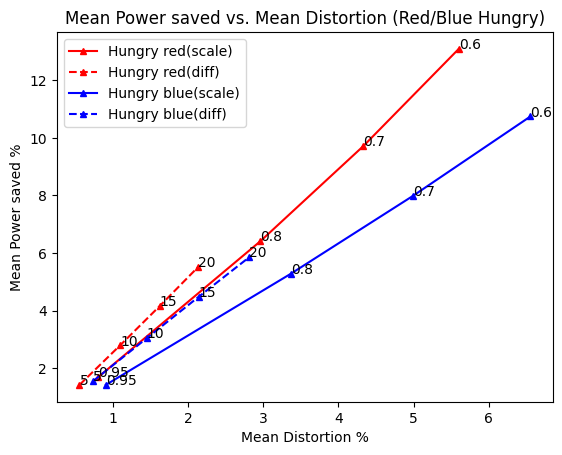

In [ ]:
plt.plot(mean_red_mul.distortion_list(), mean_red_mul.power_list(), label=f'Hungry red(scale)', marker='^', markersize=4, color='red')
plt.plot(mean_red_diff.distortion_list(), mean_red_diff.power_list(), label=f'Hungry red(diff)', marker='^', markersize=4, color='red', linestyle='--')

plt.plot(mean_blue_mul.distortion_list(), mean_blue_mul.power_list(), label=f'Hungry blue(scale)', marker='^', markersize=4, color='blue')
plt.plot(mean_blue_diff.distortion_list(), mean_blue_diff.power_list(), label=f'Hungry blue(diff)', marker='^', markersize=4, color='blue', linestyle='--')
for i, constraint in enumerate(constraints_hungry):
    plt.text(mean_red_mul.distortion_list()[i], mean_red_mul.power_list()[i], f'{constraint}')
    plt.text(mean_blue_mul.distortion_list()[i], mean_blue_mul.power_list()[i], f'{constraint}')
    plt.text(mean_red_diff.distortion_list()[i], mean_red_diff.power_list()[i], f'{(i+1)*5}')
    plt.text(mean_blue_diff.distortion_list()[i], mean_blue_diff.power_list()[i], f'{(i+1)*5}')



plt.xlabel('Mean Distortion %')
plt.ylabel('Mean Power saved %')
plt.title('Mean Power saved vs. Mean Distortion (Red/Blue Hungry)')
plt.legend()
plt.show()


In [ ]:
red_diff_20 = func.Distortion_list([])
count = 0
for image in func.progressbar(func.DATASET, "Computing: ", 40):
    obj_image = Image.open(os.path.join(func.DATASET_PATH, image))
    #print(f"processing {image}")
    if obj_image.mode == "RGB" :
        image_array = np.array(obj_image)
        func.red_distortion_diff(image_array, red_diff_20.list, 20) #scaling saturation contribution
    count += 1

Computing: [████████████████████████████████████████] 218/218 Est wait 00:0.04



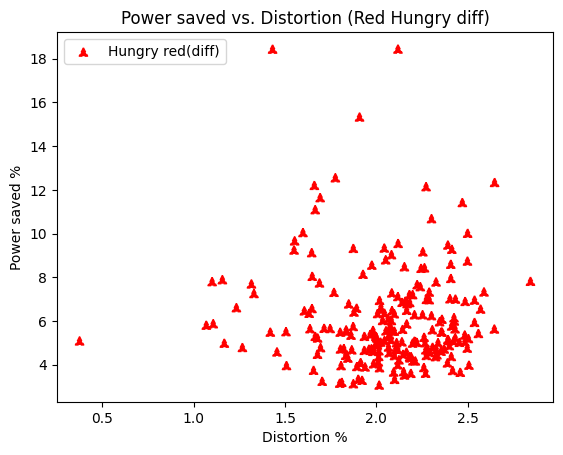

In [339]:
plt.scatter(red_diff_20.distortion_list(), red_diff_20.power_list(), label=f'Hungry red(diff)', marker='^',  color='red', linestyle='--')
plt.xlabel('Distortion %')
plt.ylabel('Power saved %')
plt.title('Power saved vs. Distortion (Red Hungry diff)')
plt.legend()
plt.show()

108
178
44
110


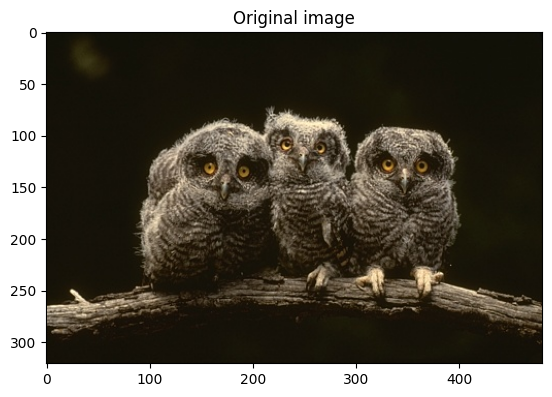

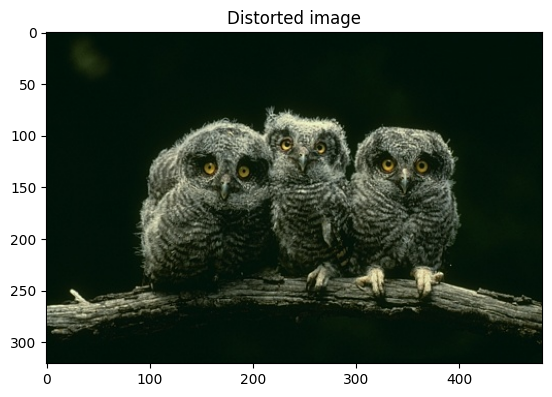

power gained: 18.450344828977624%
distortion from original: 2.118974239032224%


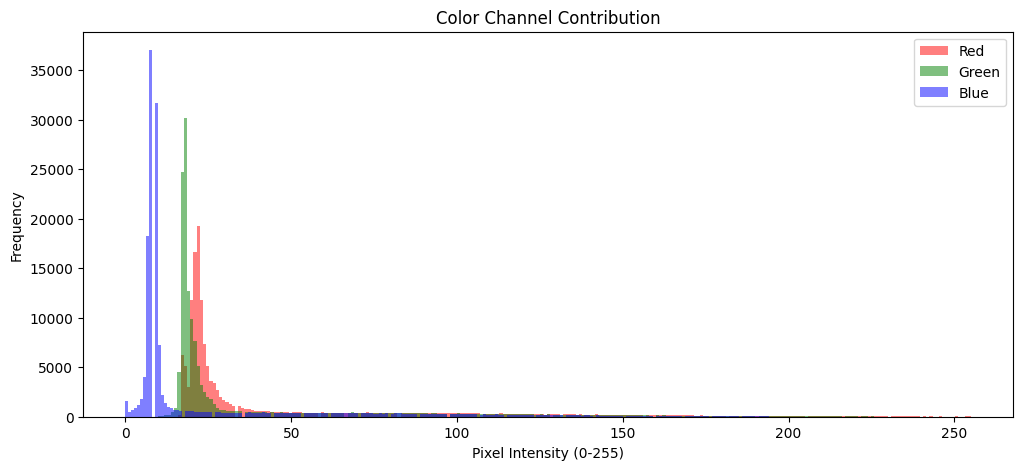

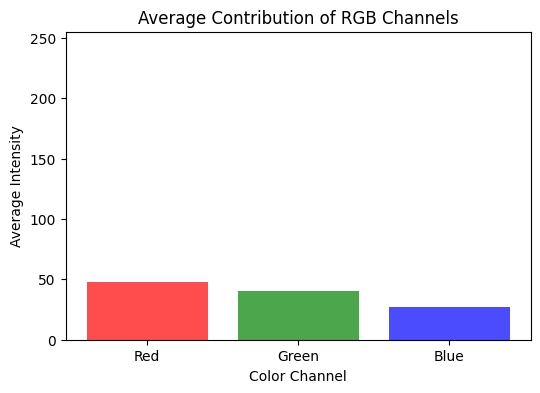

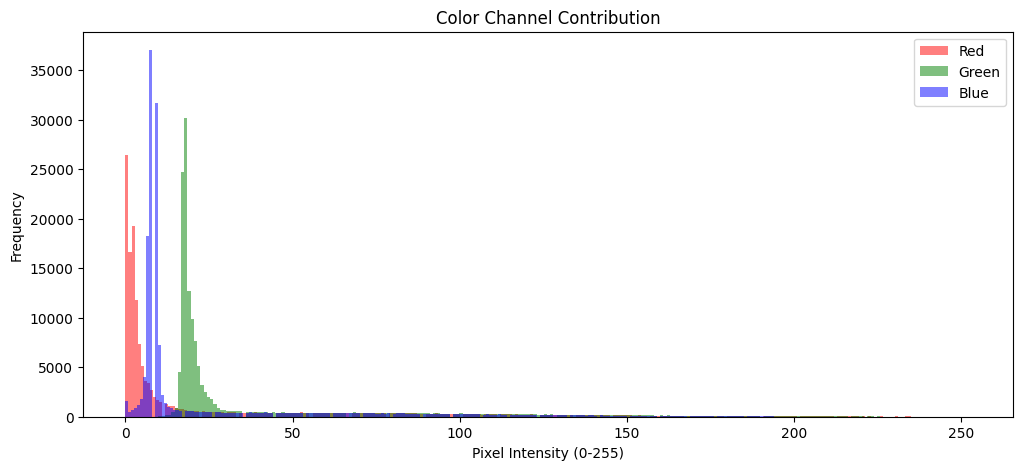

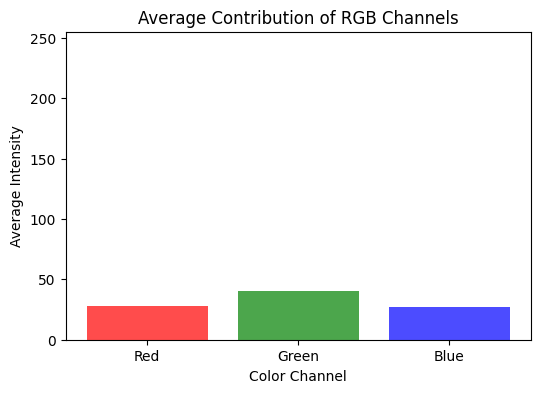

Red hungry - Max power gain


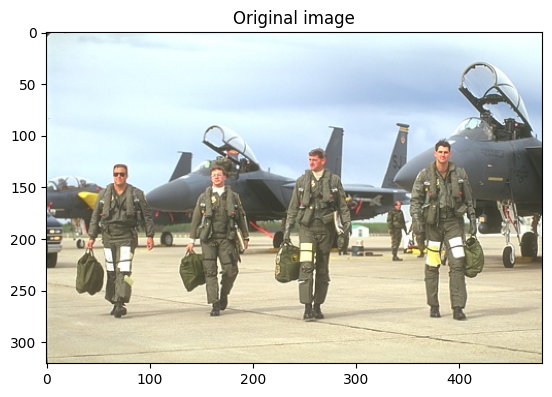

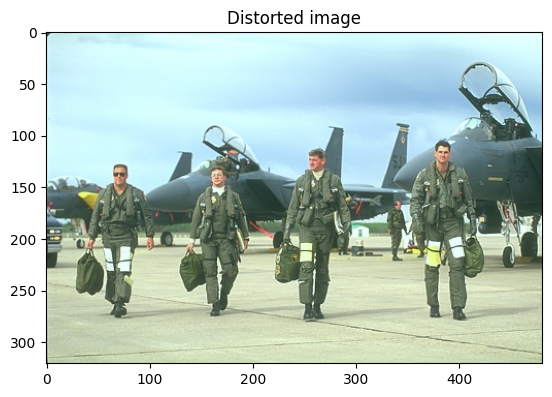

power gained: 3.0712312494911376%
distortion from original: 2.0161601224693864%


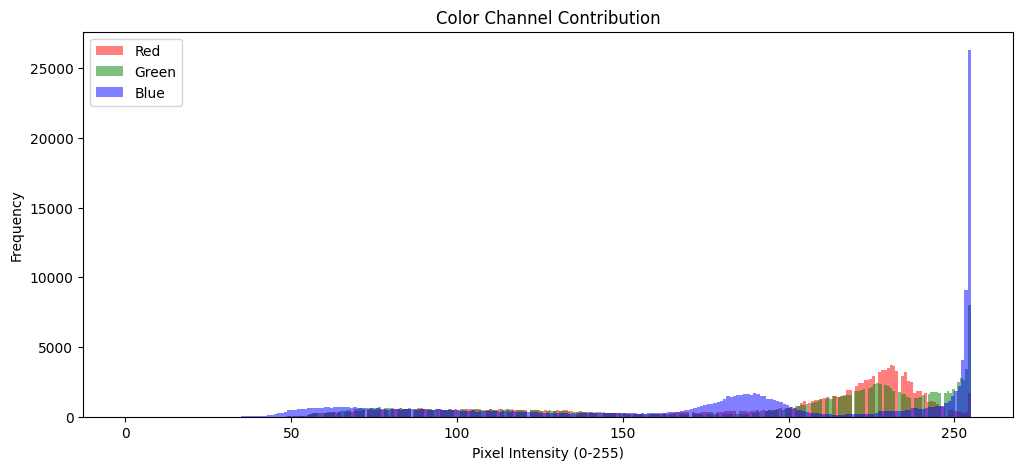

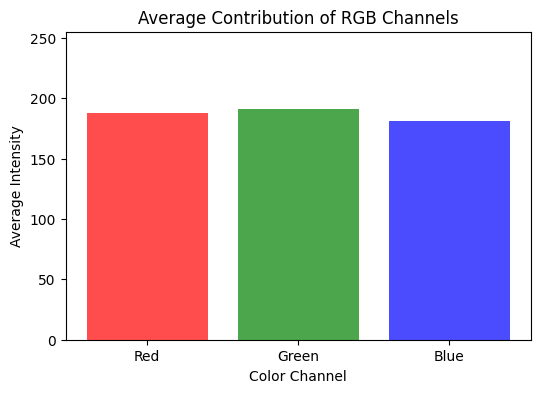

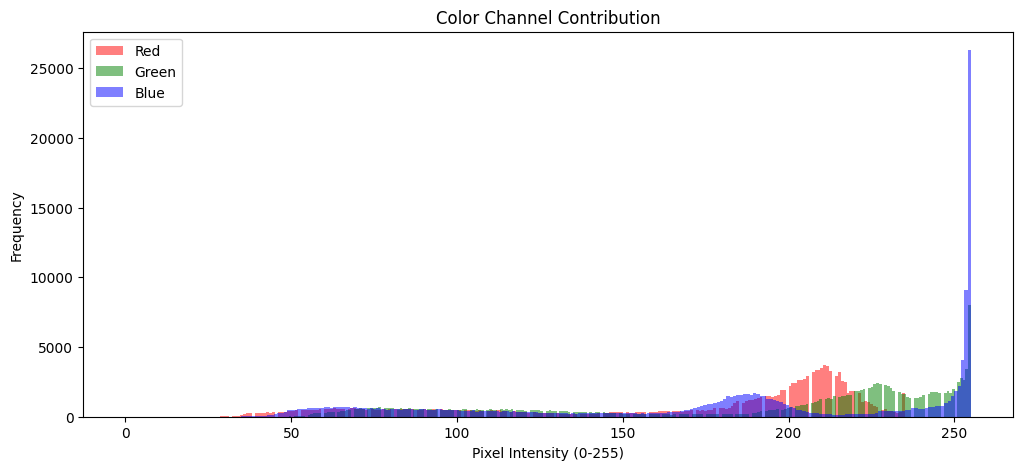

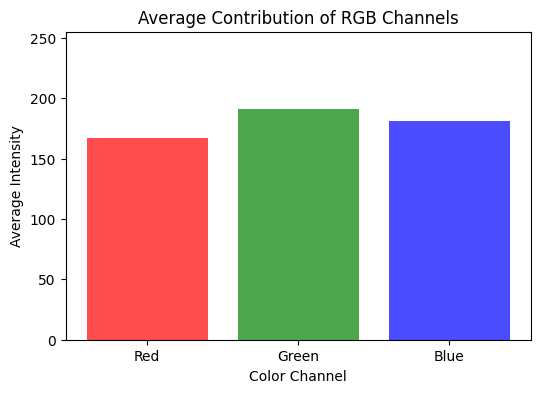

Red hungry - Min power gain


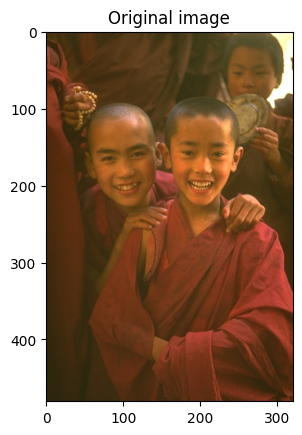

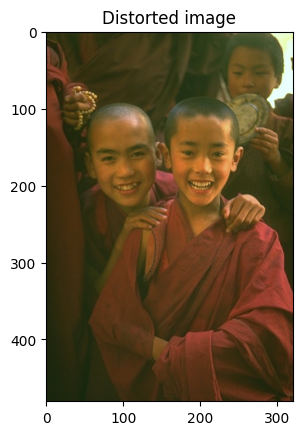

power gained: 7.820589475452964%
distortion from original: 2.844541277616826%


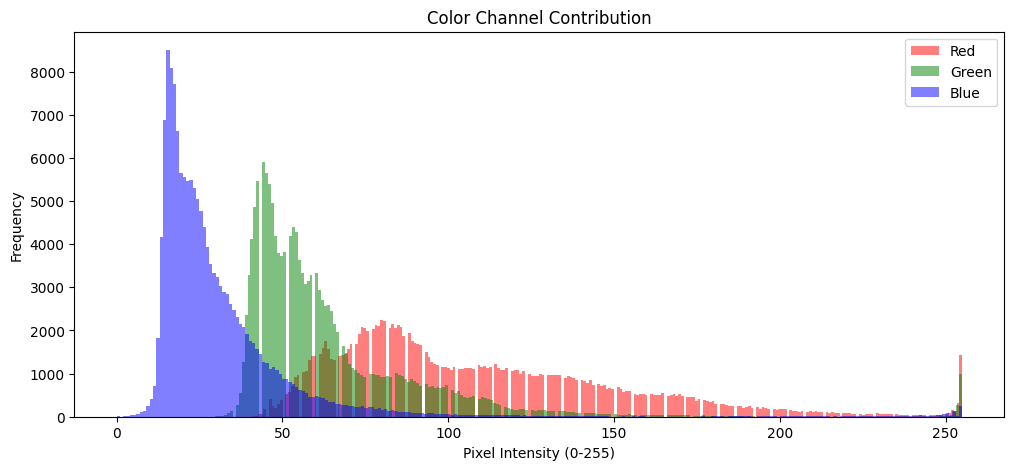

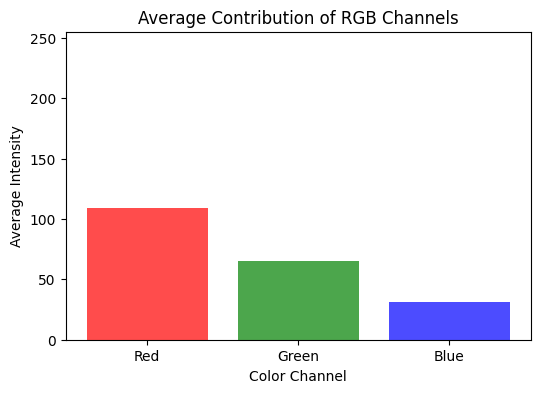

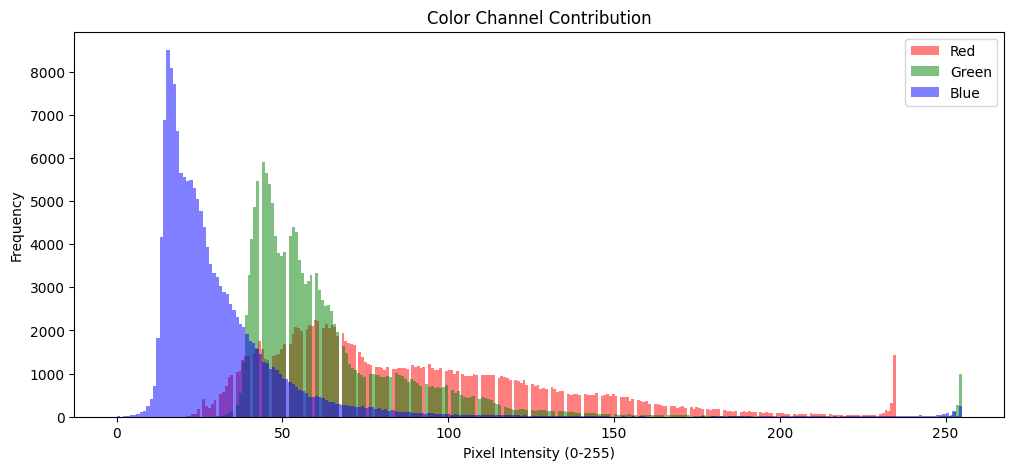

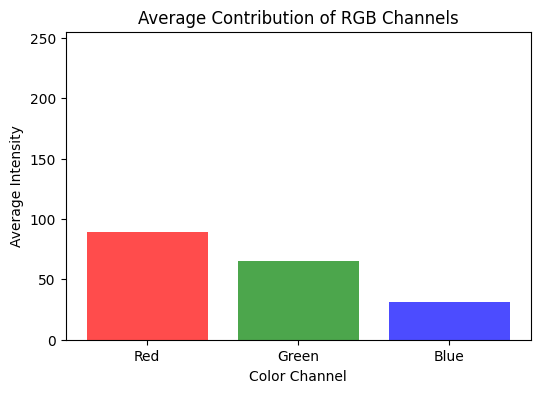

Red hungry - Max distortion


In [346]:
pareto_red_diff = func.min_max(red_diff_20.distortion_list(), red_diff_20.power_list())

func.show_image_diff(func.DATASET,pareto_red_diff.max_power_gain_index,func.red_distortion_diff)
print("Red hungry - Max power gain")
func.show_image_diff(func.DATASET,pareto_red_diff.min_power_gain_index,func.red_distortion_diff)
print("Red hungry - Min power gain")
func.show_image_diff(func.DATASET,pareto_red_diff.max_distortion_index,func.red_distortion_diff)
print("Red hungry - Max distortion")


## Value and Saturation hist equalization

In [ ]:
hist_eq_S_dist = func.Distortion_list()
hist_eq_V_dist = func.Distortion_list()

count = 0


for image in func.progressbar(func.DATASET, "Computing: ", 40):
    obj_image = Image.open(os.path.join(func.DATASET_PATH, image))
    
    if obj_image.mode == "RGB":
        image_array = np.array(obj_image)
        func.hist_eq_S(image_array, hist_eq_S_dist.list) #equalize S hist
        func.hist_eq_V(image_array, hist_eq_V_dist.list) 


    count += 1

#save data for futher computation and graph
np.save(f'{func.DATASET_PATH}/hist_eq_S_dist.npy', np.array(hist_eq_S_dist))
np.save(f'{func.DATASET_PATH}/hist_eq_V_dist.npy', np.array(hist_eq_V_dist))


Computing: [████████████████████████████████████████] 5/5 Est wait 00:0.030



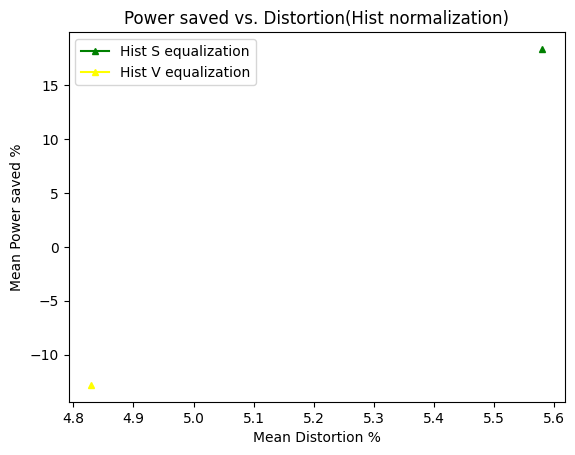

In [ ]:
plt.plot(statistics.mean(hist_eq_S_dist.distortion_list()), statistics.mean(hist_eq_S_dist.power_list()), label=f'Hist S equalization', marker='^', markersize=4, color='green')
plt.plot(statistics.mean(hist_eq_V_dist.distortion_list()), statistics.mean(hist_eq_V_dist.power_list()), label=f'Hist V equalization', marker='^', markersize=4, color='yellow')

plt.xlabel('Mean Distortion %')
plt.ylabel('Mean Power saved %')
plt.title('Power saved vs. Distortion(Hist normalization)')
plt.legend()
plt.show()


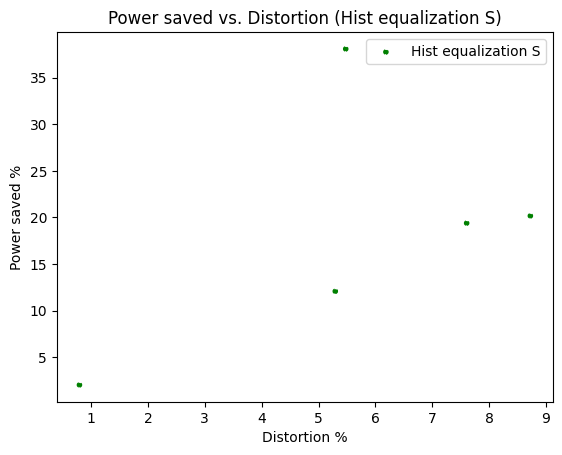

In [360]:
plt.scatter(hist_eq_S_dist.distortion_list(), hist_eq_S_dist.power_list(), label=f'Hist equalization S', marker='.',  color='green', linestyle='--')
plt.xlabel('Distortion %')
plt.ylabel('Power saved %')
plt.title('Power saved vs. Distortion (Hist equalization S)')
plt.legend()
plt.show()

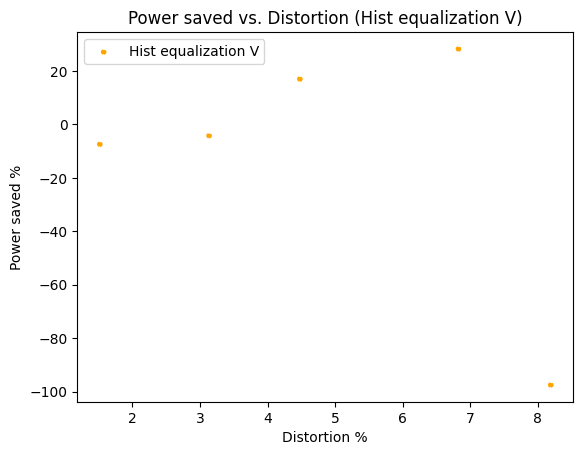

In [361]:
plt.scatter(hist_eq_V_dist.distortion_list(), hist_eq_V_dist.power_list(), label=f'Hist equalization V', marker='.',  color='orange', linestyle='--')
plt.xlabel('Distortion %')
plt.ylabel('Power saved %')
plt.title('Power saved vs. Distortion (Hist equalization V)')
plt.legend()
plt.show()

44
45
52
11
166
178
38
166


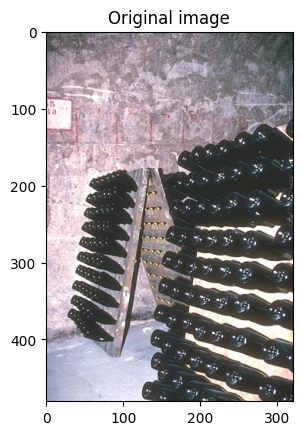

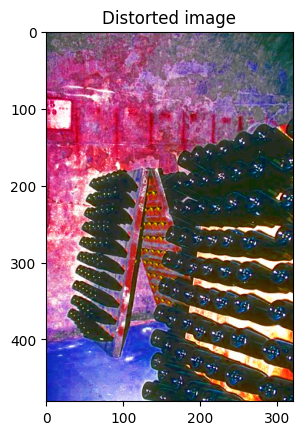

power gained: 18.30615458134421%
distortion from original: 7.623861625060144%


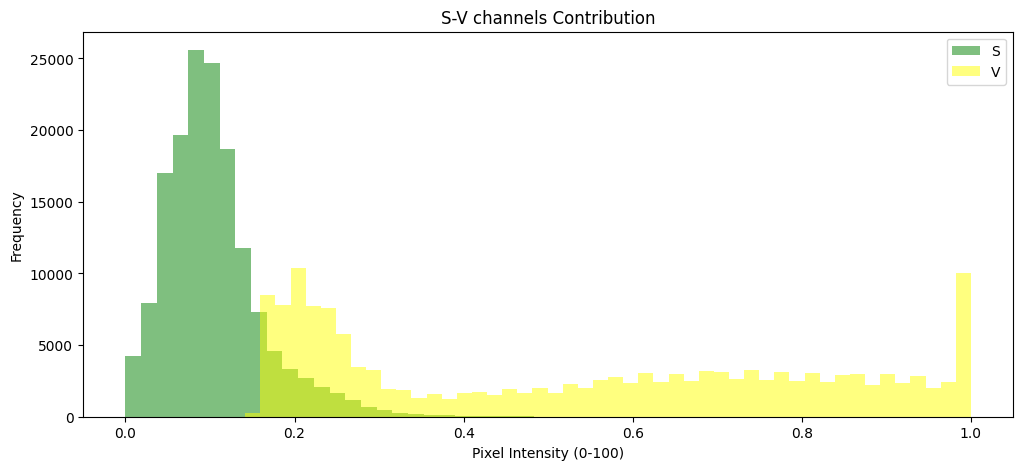

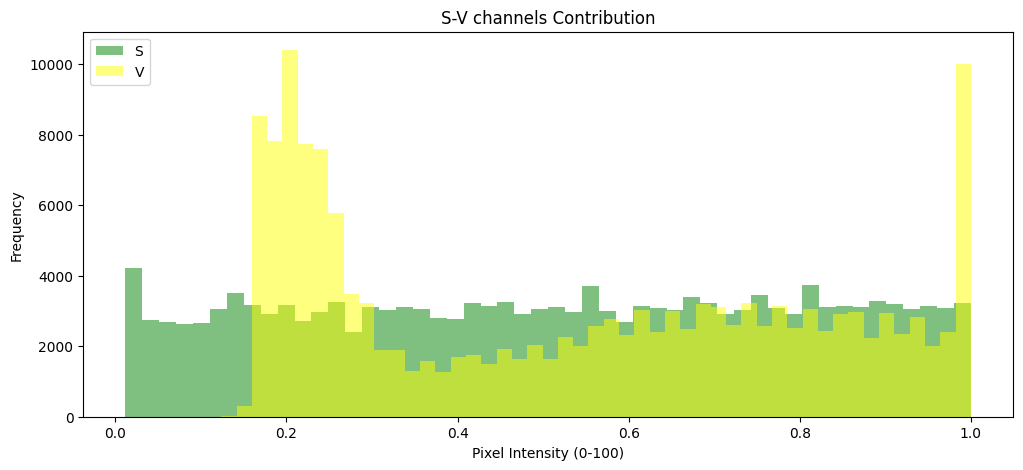

Hist S equalization - Max power gain


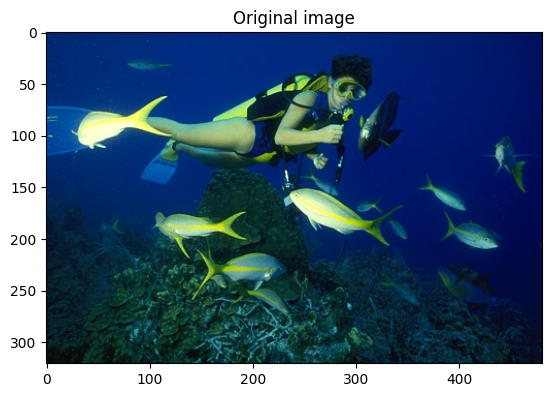

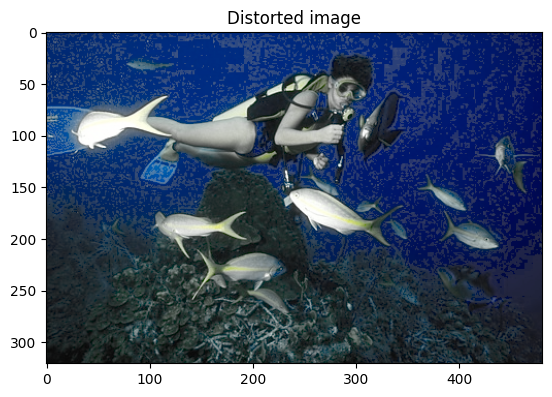

power gained: -21.485122399311877%
distortion from original: 3.069251146074294%


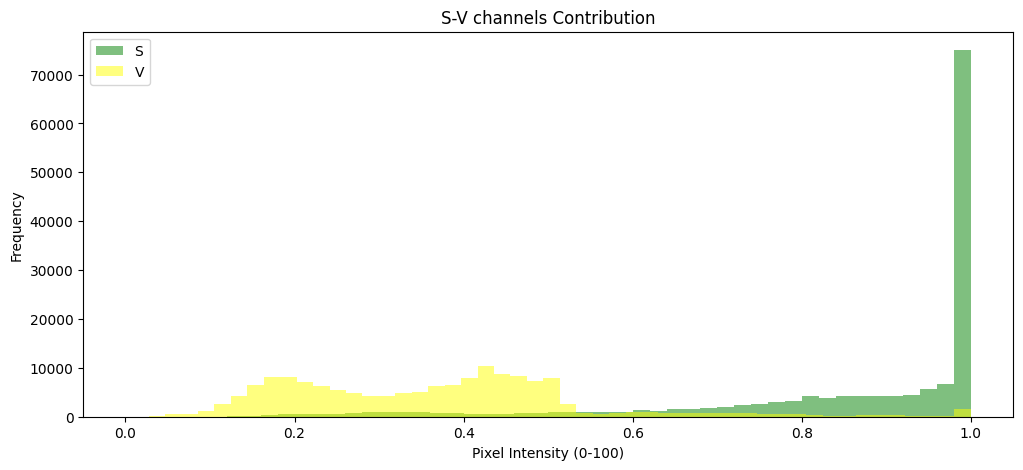

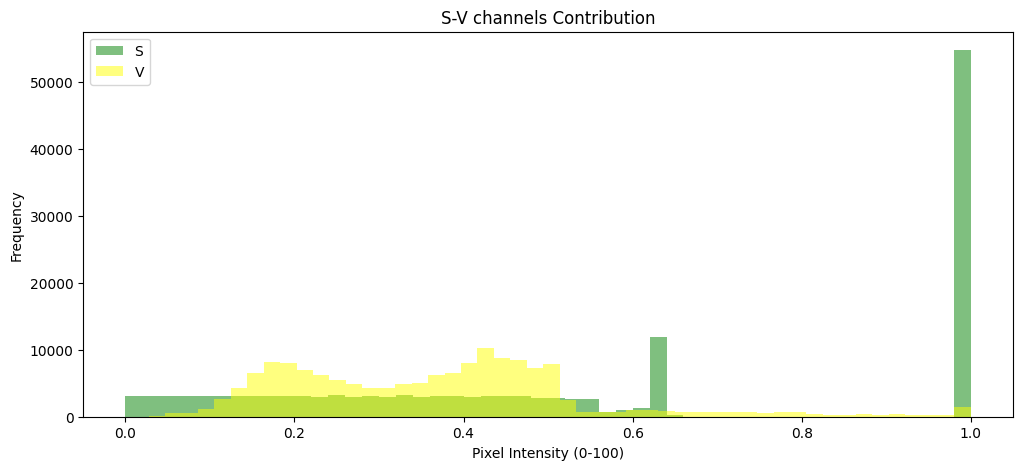

Hist S equalization - Min power gain


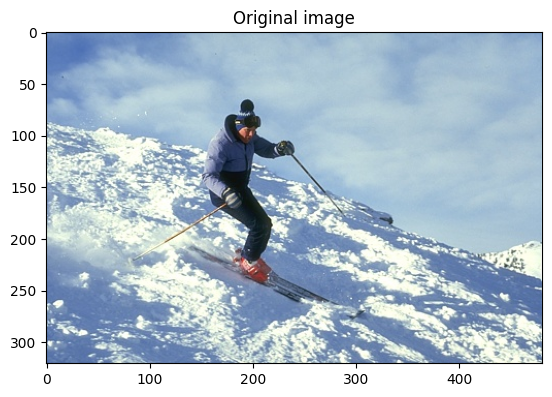

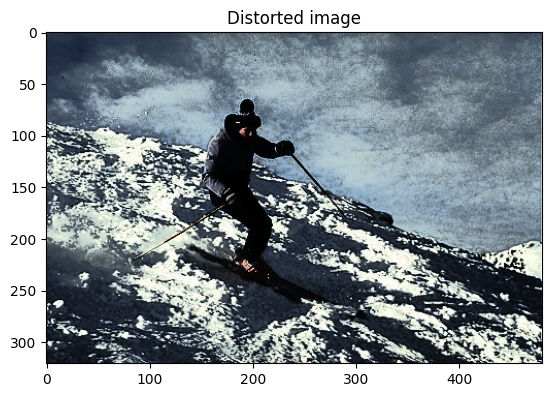

power gained: 30.078019277521317%
distortion from original: 6.762320186233292%


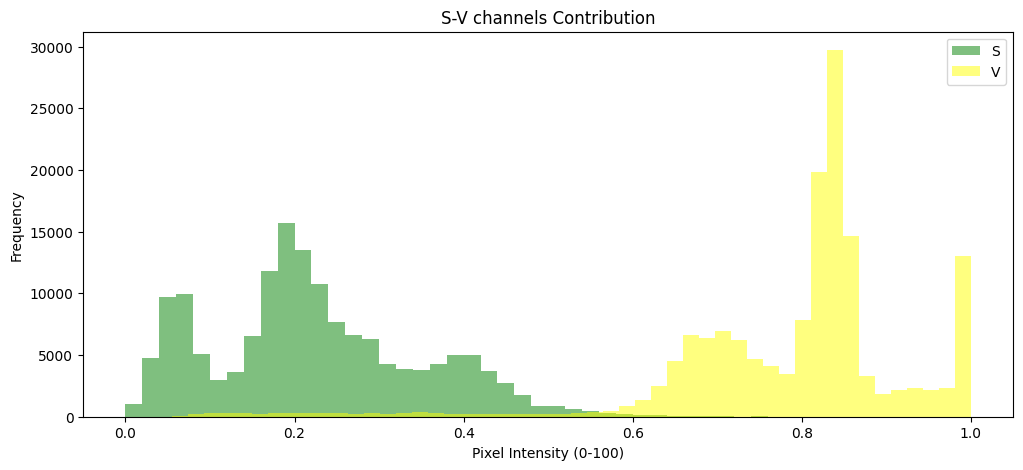

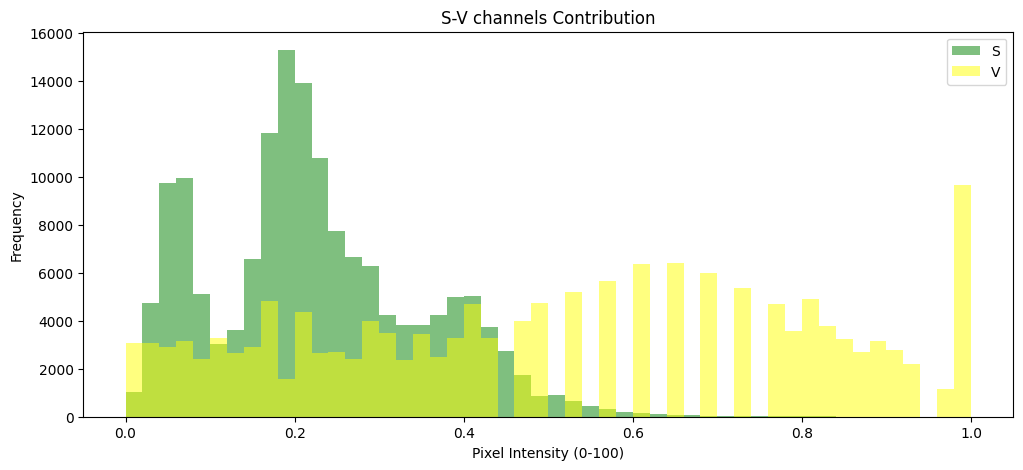

Hist V equalization - Max power gain


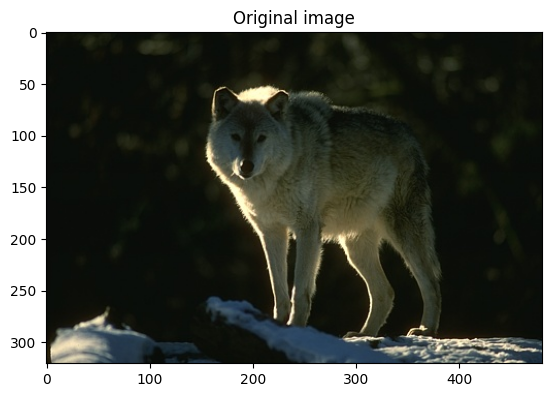

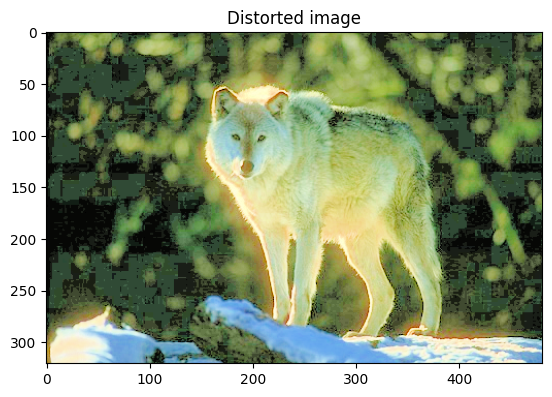

power gained: -172.97094988905687%
distortion from original: 11.408538223928284%


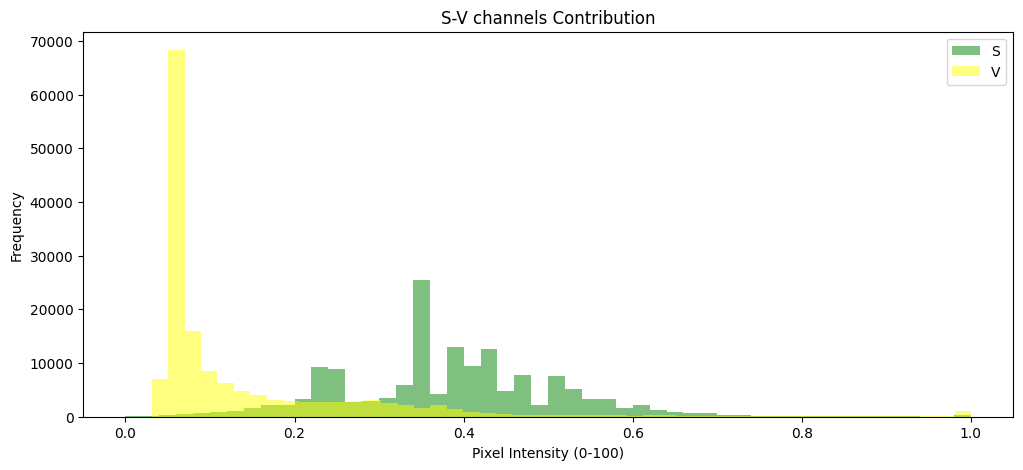

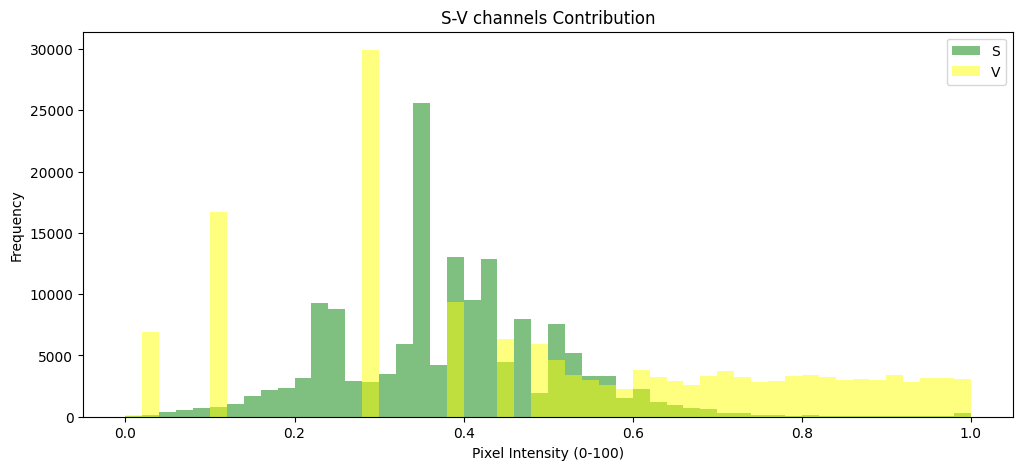

Hist V equalization - Min power gain


In [373]:
hist_eq_S_dist = np.load(f"{func.DATASET_PATH}/hist_eq_S_dist.npy", allow_pickle=True).tolist()
hist_eq_V_dist = np.load(f"{func.DATASET_PATH}/hist_eq_V_dist.npy", allow_pickle=True).tolist()

pareto_hist_eq_s = func.min_max(hist_eq_S_dist.distortion_list(), hist_eq_S_dist.power_list())
pareto_hist_eq_v = func.min_max(hist_eq_V_dist.distortion_list(), hist_eq_V_dist.power_list())


func.show_image_hist(func.DATASET,pareto_hist_eq_s.max_power_gain_index,func.hist_eq_S)
print("Hist S equalization - Max power gain")
func.show_image_hist(func.DATASET,pareto_hist_eq_s.min_power_gain_index,func.hist_eq_S)
print("Hist S equalization - Min power gain")


func.show_image_hist(func.DATASET,pareto_hist_eq_v.max_power_gain_index,func.hist_eq_V)
print("Hist V equalization - Max power gain")
func.show_image_hist(func.DATASET,pareto_hist_eq_v.min_power_gain_index,func.hist_eq_V)
print("Hist V equalization - Min power gain")


## Value and Saturation scale

In [ ]:
S_scale_dist_12 = func.Distortion_list([])
S_scale_dist_14 = func.Distortion_list([])
S_scale_dist_16 = func.Distortion_list([])
S_scale_dist_18 = func.Distortion_list([])
V_scale_dist_75 = func.Distortion_list([])
V_scale_dist_85 = func.Distortion_list([])
V_scale_dist_90 = func.Distortion_list([])
V_scale_dist_95 = func.Distortion_list([])

count = 0


for image in func.progressbar(func.DATASET, "Computing: ", 40):
    obj_image = Image.open(os.path.join(func.DATASET_PATH, image))
    if obj_image.mode == "RGB":
        image_array = np.array(obj_image)
        func.S_scale(image_array, S_scale_dist_12.list, 1.2) #scaling saturation contribution
        func.S_scale(image_array, S_scale_dist_14.list, 1.4) 
        func.S_scale(image_array, S_scale_dist_16.list, 1.6)
        func.S_scale(image_array, S_scale_dist_18.list, 1.8)
        func.V_scale(image_array, V_scale_dist_75.list, 0.75)
        func.V_scale(image_array, V_scale_dist_85.list, 0.85) #scaling brightness contribution
        func.V_scale(image_array, V_scale_dist_90.list, 0.90)
        func.V_scale(image_array, V_scale_dist_95.list, 0.95)

    count += 1

#save data for futher computation and graph
np.save(f'{func.DATASET_PATH}/S_scale_dist_12.npy', np.array(S_scale_dist_12))
np.save(f'{func.DATASET_PATH}/S_scale_dist_14.npy', np.array(S_scale_dist_14))
np.save(f'{func.DATASET_PATH}/S_scale_dist_16.npy', np.array(S_scale_dist_16))
np.save(f'{func.DATASET_PATH}/S_scale_dist_18.npy', np.array(S_scale_dist_18))
np.save(f'{func.DATASET_PATH}/V_scale_dist_75.npy', np.array(V_scale_dist_75))
np.save(f'{func.DATASET_PATH}/V_scale_dist_85.npy', np.array(V_scale_dist_85))
np.save(f'{func.DATASET_PATH}/V_scale_dist_90.npy', np.array(V_scale_dist_90))
np.save(f'{func.DATASET_PATH}/V_scale_dist_95.npy', np.array(V_scale_dist_95))


Computing: [████████████████████████████████████████] 5/5 Est wait 00:0.010



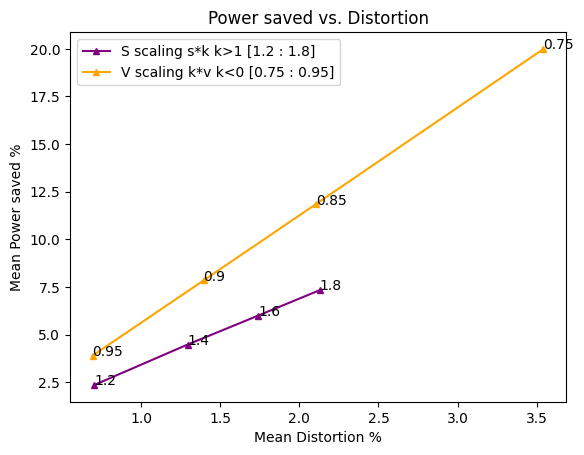

In [ ]:
#S-H scaling
s_scale_dist = [statistics.mean(S_scale_dist_12.distortion_list()), statistics.mean(S_scale_dist_14.distortion_list()), statistics.mean(S_scale_dist_16.distortion_list()), statistics.mean(S_scale_dist_18.distortion_list())]
s_scale_power = [statistics.mean(S_scale_dist_12.power_list()), statistics.mean(S_scale_dist_14.power_list()), statistics.mean(S_scale_dist_16.power_list()),statistics.mean(S_scale_dist_18.power_list())]
v_scale_dist = [statistics.mean(V_scale_dist_75.distortion_list()), statistics.mean(V_scale_dist_85.distortion_list()), statistics.mean(V_scale_dist_90.distortion_list()), statistics.mean(V_scale_dist_95.distortion_list())]
v_scale_power = [statistics.mean(V_scale_dist_75.power_list()), statistics.mean(V_scale_dist_85.power_list()), statistics.mean(V_scale_dist_90.power_list()), statistics.mean(V_scale_dist_95.power_list())]

plt.plot(s_scale_dist, s_scale_power, label='S scaling s*k k>1 [1.2 : 1.8]', marker='^', markersize=4, color='purple')
plt.plot(v_scale_dist, v_scale_power, label='V scaling k*v k<0 [0.75 : 0.95]', marker='^', markersize=4, color='orange')
v_s_constraint = [[1.2, 0.75], [1.4, 0.85], [1.6, 0.90], [1.8, 0.95]]
for i, constraint in enumerate(v_s_constraint):
    plt.text(s_scale_dist[i], s_scale_power[i], f'{constraint[0]}')
    plt.text(v_scale_dist[i], v_scale_power[i], f'{constraint[1]}')


plt.xlabel('Mean Distortion %')
plt.ylabel('Mean Power saved %')
plt.title('Power saved vs. Distortion')
plt.legend()
plt.show()

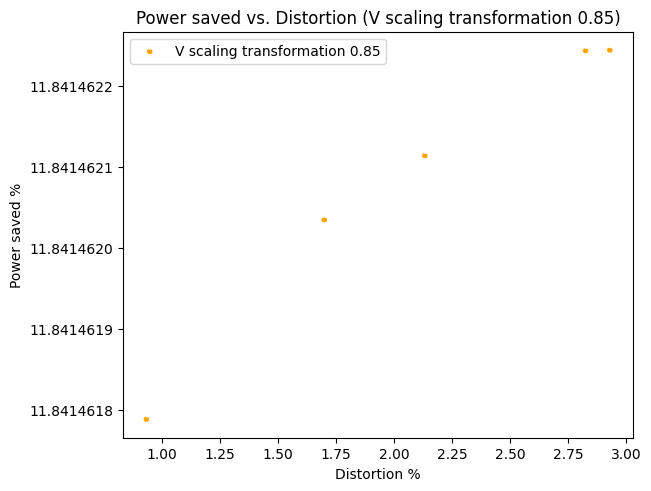

[np.float64(11.84146211409841), np.float64(11.841462243811932), np.float64(11.84146224454624), np.float64(11.84146203497019), np.float64(11.841461788523008)]


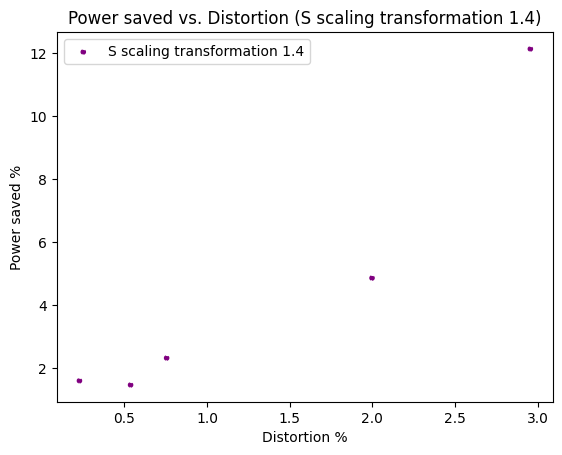

[np.float64(1.4749720711250742), np.float64(4.865299567463176), np.float64(2.3284660534563555), np.float64(12.129472200930993), np.float64(1.606877172235697)]


In [457]:
fig, ax = plt.subplots(layout='constrained')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)

ax.scatter(V_scale_dist_85.distortion_list(), V_scale_dist_85.power_list(), label=f'V scaling transformation 0.85', marker='.',  color='orange', linestyle='--')
plt.xlabel('Distortion %')
plt.ylabel('Power saved %')
plt.title('Power saved vs. Distortion (V scaling transformation 0.85)')
plt.legend()
plt.show()

print(V_scale_dist_85.power_list())

plt.scatter(S_scale_dist_14.distortion_list(), S_scale_dist_14.power_list(), label=f'S scaling transformation 1.4', marker='.',  color='purple', linestyle='--')
plt.xlabel('Distortion %')
plt.ylabel('Power saved %')
plt.title('Power saved vs. Distortion (S scaling transformation 1.4)')
plt.legend()
plt.show()

print(S_scale_dist_14.power_list())

In [ ]:
pareto_s_scale = func.min_max(S_scale_dist_16.distortion_list(), S_scale_dist_16.power_list())
pareto_v_scale = func.min_max(V_scale_dist_85.distortion_list(), V_scale_dist_85.power_list())

func.show_image_s(func.DATASET,pareto_s_scale.max_power_gain_index,func.S_scale)
print("S scaling - Max power gain")
func.show_image_s(func.DATASET,pareto_s_scale.min_power_gain_index,func.S_scale)
print("S scaling - Min power gain")
func.show_image_s(func.DATASET,pareto_s_scale.max_distortion_index,func.S_scale)
print("S scaling - Max distortion")
func.show_image_s(func.DATASET,pareto_s_scale.min_distortion_index,func.S_scale)
print("S scaling - Min distortion")


func.show_image_v(func.DATASET,pareto_v_scale.max_power_gain_index,func.V_scale)
print("V scaling - Max power gain")
func.show_image_v(func.DATASET,pareto_v_scale.min_power_gain_index,func.V_scale)
print("V scaling - Min power gain")
func.show_image_v(func.DATASET,pareto_v_scale.max_distortion_index,func.V_scale)
print("V scaling - Max distortion")
func.show_image_v(func.DATASET,pareto_v_scale.min_distortion_index,func.V_scale)
print("V scaling - Min distortion")


## Apply V+S scaling

In [ ]:
constraints = [[0.98,1.2], [0.95,1.2], [0.80,1.2], [0.75,1.2], [0.80,1.6]]
V_S_scale_dist_objects = [func.Distortion_list([]) for _ in constraints]  # Dictionary to store Distortion_list objects

count = 0
for image in func.progressbar(func.DATASET, "Computing: ", 40):
    obj_image = Image.open(os.path.join(func.DATASET_PATH, image))
    if obj_image.mode == "RGB":
        image_array = np.array(obj_image)
        for i, contraint in enumerate(constraints):
            func.V_S_scale(image_array, V_S_scale_dist_objects[i].list, contraint[0], contraint[1]) #scaling saturation contribution
    count += 1

#save data for futher computation and graph
for i, constraint in enumerate(constraints):
    filename = f"V_S_scale_dist_{int(constraint[0] * 100)}_{int(constraint[1] * 10)}.npy"
    np.save(filename, np.array(V_S_scale_dist_objects[i]))

Computing: [████████████████████████████████████████] 5/5 Est wait 00:0.070



In [459]:
mean_blue_diff = func.Distortion_list([])
mean_blue_mul = func.Distortion_list([])
mean_red_diff = func.Distortion_list([])
mean_red_mul = func.Distortion_list([])

#load saved data for graph computation
for i, constraint in enumerate(constraints_hungry):
    filename = f"{func.DATASET_PATH}/blue_diff_{(i+1)*5}.npy"
    mean = np.load(filename, allow_pickle = True).tolist()
    mean_blue_diff.list.append([statistics.mean(mean.distortion_list()), statistics.mean(mean.power_list())])
    filename = f"{func.DATASET_PATH}/blue_mul_{constraint}.npy"
    mean = np.load(filename, allow_pickle = True).tolist()
    mean_blue_mul.list.append([statistics.mean(mean.distortion_list()), statistics.mean(mean.power_list())])
    filename = f"{func.DATASET_PATH}/red_diff_{(i+1)*5}.npy"
    mean = np.load(filename, allow_pickle = True).tolist()
    mean_red_diff.list.append([statistics.mean(mean.distortion_list()), statistics.mean(mean.power_list())])
    filename = f"{func.DATASET_PATH}/red_mul_{constraint}.npy"
    mean = np.load(filename, allow_pickle = True).tolist()
    mean_red_mul.list.append([statistics.mean(mean.distortion_list()), statistics.mean(mean.power_list())])

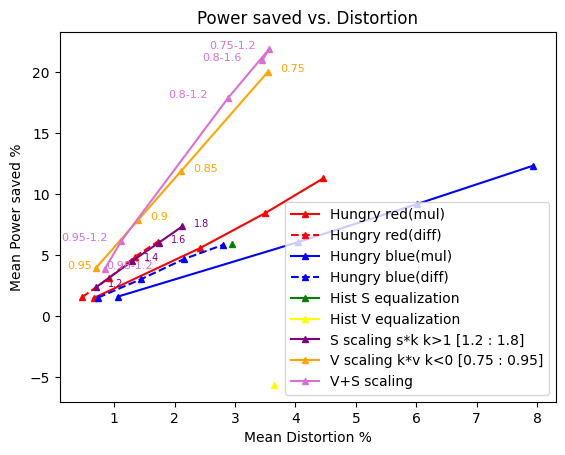

In [ ]:
#rgb red-blue hungry
plt.plot(mean_red_mul.distortion_list(), mean_red_mul.power_list(), label=f'Hungry red(mul)', marker='^', markersize=4, color='red')
plt.plot(mean_red_diff.distortion_list(), mean_red_diff.power_list(), label=f'Hungry red(diff)', marker='^', markersize=4, color='red', linestyle='--')
#plt.text(mean_red_mul.distortion_list()[-1], mean_red_mul.power_list()[-1], '0.95')
#plt.text(mean_red_diff.distortion_list()[-1], mean_red_diff.power_list()[-1], '24')

plt.plot(mean_blue_mul.distortion_list(), mean_blue_mul.power_list(), label=f'Hungry blue(mul)', marker='^', markersize=4, color='blue')
plt.plot(mean_blue_diff.distortion_list(), mean_blue_diff.power_list(), label=f'Hungry blue(diff)', marker='^', markersize=4, color='blue', linestyle='--')
#plt.text(mean_blue_mul.distortion_list()[-1], mean_blue_mul.power_list()[-1], '0.95')
#plt.text(mean_blue_diff.distortion_list()[-1], mean_blue_diff.power_list()[-1], '24')

#S-H hist equalization
plt.plot(statistics.mean(hist_eq_S_dist.distortion_list()), statistics.mean(hist_eq_S_dist.power_list()), label=f'Hist S equalization', marker='^', markersize=4, color='green')
plt.plot(statistics.mean(hist_eq_V_dist.distortion_list()), statistics.mean(hist_eq_V_dist.power_list()), label=f'Hist V equalization', marker='^', markersize=4, color='yellow')

#S-H scaling
#s_scale_dist = [statistics.mean(S_scale_dist_12.distortion_list()), statistics.mean(S_scale_dist_14.distortion_list()), statistics.mean(S_scale_dist_16.distortion_list())]
#s_scale_power = [statistics.mean(S_scale_dist_12.power_list()), statistics.mean(S_scale_dist_14.power_list()), statistics.mean(S_scale_dist_16.power_list())]
#v_scale_dist = [statistics.mean(V_scale_dist_85.distortion_list()), statistics.mean(V_scale_dist_90.distortion_list()), statistics.mean(V_scale_dist_95.distortion_list())]
#v_scale_power = [statistics.mean(V_scale_dist_85.power_list()), statistics.mean(V_scale_dist_90.power_list()), statistics.mean(V_scale_dist_95.power_list())]

plt.plot(s_scale_dist, s_scale_power, label='S scaling s*k k>1 [1.2 : 1.8]', marker='^', markersize=4, color='purple')
plt.plot(v_scale_dist, v_scale_power, label='V scaling k*v k<0 [0.75 : 0.95]', marker='^', markersize=4, color='orange')
v_s_constraint = [[1.2, 0.75], [1.4, 0.85], [1.6, 0.90], [1.8, 0.95]]
for i, constraint in enumerate(v_s_constraint):
    plt.text(s_scale_dist[i]+0.2, s_scale_power[i], f'{constraint[0]}', size=7 , color = 'purple')
    if i == 3:
        plt.text(v_scale_dist[i]-0.47, v_scale_power[i], f'{constraint[1]}', size=8 , color='orange')
    else: 
        plt.text(v_scale_dist[i]+0.2, v_scale_power[i], f'{constraint[1]}', size=8 , color='orange')

#v+s scaling
vs_scaling_dist = []
vs_scaling_power = []
for i, constraint in enumerate(constraints):
    vs_scaling_dist.append(statistics.mean(V_S_scale_dist_objects[i].distortion_list()))
    vs_scaling_power.append(statistics.mean(V_S_scale_dist_objects[i].power_list()))

plt.plot(vs_scaling_dist, vs_scaling_power, label=f'V+S scaling', marker='^', markersize=4, color='orchid')
for i, constraint in enumerate(constraints):
    if i == 0:
        plt.text(vs_scaling_dist[i]+.015, vs_scaling_power[i], f'{constraint[0]}-{constraint[1]}', size=8 , color='orchid')
    else:
        plt.text(vs_scaling_dist[i]-1.0, vs_scaling_power[i], f'{constraint[0]}-{constraint[1]}', size=8 , color='orchid')


#plt.plot(statistics.mean(hist_eq_V_dist.distortion_list()), statistics.mean(hist_eq_V_dist.power_list()), label=f'Hist V equalization', marker='^', markersize=4, color='yellow')


plt.xlabel('Mean Distortion %')
plt.ylabel('Mean Power saved %')
plt.title('Power saved vs. Distortion')
plt.legend()
plt.show()

29
102
166
122


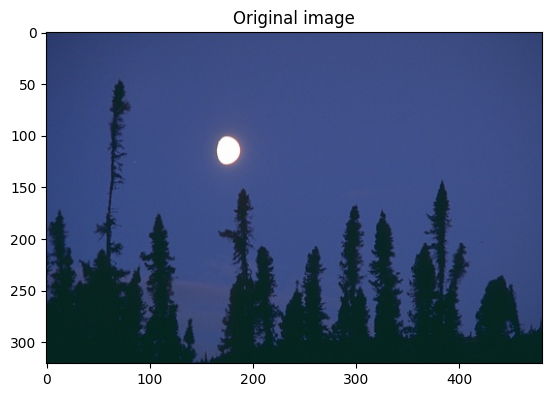

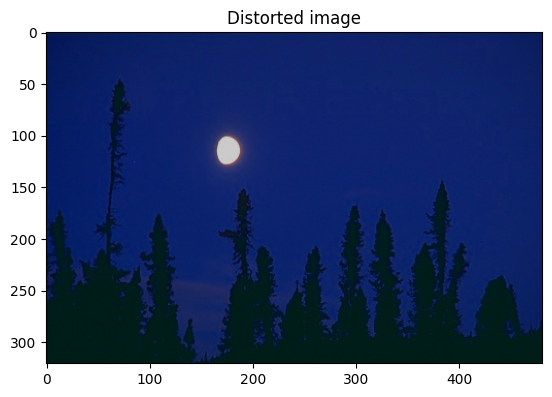

power gained: 36.50736032730305%
distortion from original: 4.850880397431005%
S scaling - Max power gain


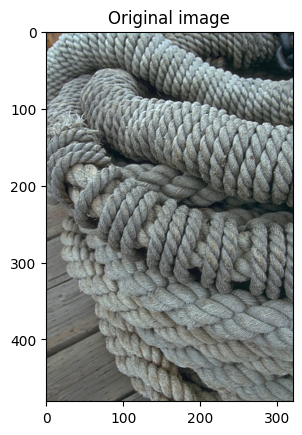

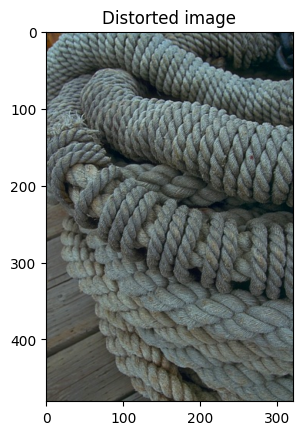

power gained: 17.261946259300913%
distortion from original: 2.643586911401503%
S scaling - Min power gain


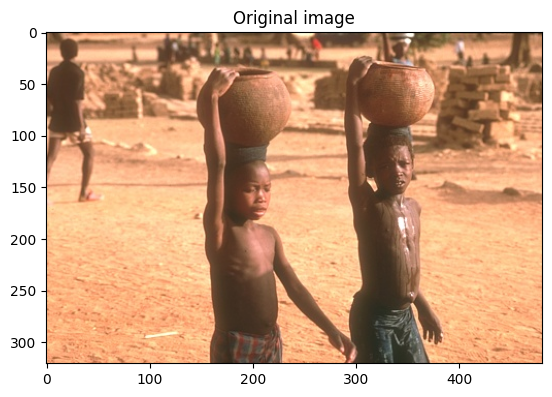

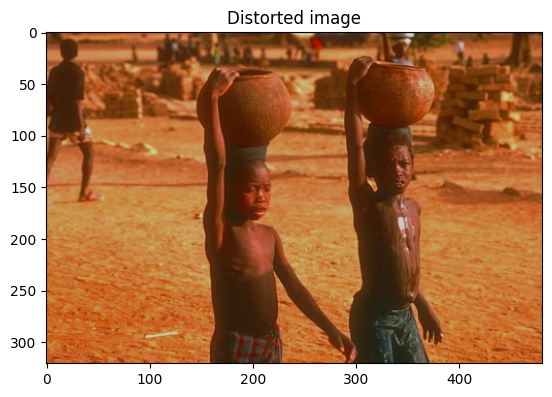

power gained: 30.1102134836614%
distortion from original: 6.076607271627095%
S scaling - Max distortion


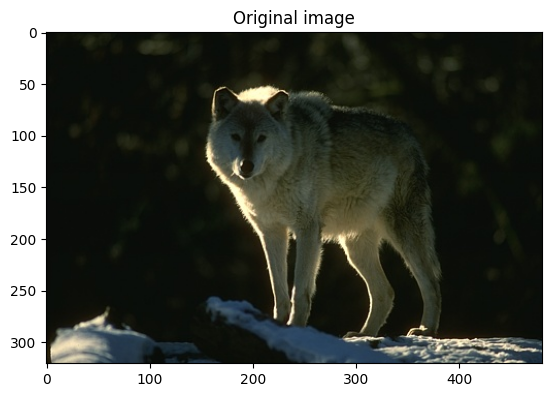

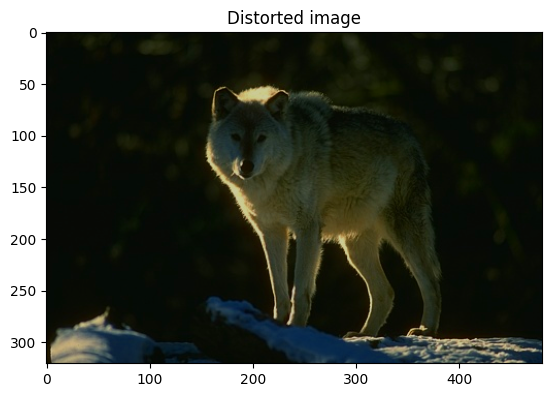

power gained: 24.700734191661375%
distortion from original: 0.9615356902688958%
S scaling - Min distortion


In [445]:
pareto_vs_scale = func.min_max(V_S_scale_dist_objects[-1].distortion_list(), V_S_scale_dist_objects[-1].power_list())

func.show_image_vs(func.DATASET,pareto_vs_scale.max_power_gain_index)
print("S scaling - Max power gain")
func.show_image_vs(func.DATASET,pareto_vs_scale.min_power_gain_index)
print("S scaling - Min power gain")
func.show_image_vs(func.DATASET,pareto_vs_scale.max_distortion_index)
print("S scaling - Max distortion")
func.show_image_vs(func.DATASET,pareto_vs_scale.min_distortion_index)
print("S scaling - Min distortion")


In [ ]:
scaling_v = [14, 13, 12, 11, 10]
dvs_scaling = [[func.Distortion_list([]), func.Distortion_list([]), func.Distortion_list([])] for _ in scaling_v]  # Dictionary to store Distortion_list objects

enha_power = 0
enha_dist = 0
mean_power_gain = 0
for image in func.progressbar(func.DATASET, "Computing: ", 40):
    obj_image = Image.open(os.path.join(func.DATASET_PATH, image))
    if obj_image.mode == "RGB":
        image_array = np.array(obj_image)
    
    for i, v_new in enumerate(scaling_v):
        #only dvs
        height, width, channels = image_array.shape
        i_vett = np.array([func.compute_pixel_current(pixel) for row in image_array for pixel in row])

        i_vett = i_vett.reshape(height, width, channels)

        original, distorted, power = func.displayed_image(i_vett, v_new)
        distortion = func.compute_distortion(image_array, distorted)
        dvs_scaling[i][0].list.append([distortion, power])

        plt.imshow(image_array)
        plt.title('Original image')
        plt.show()
        plt.imshow(distorted)
        plt.title('Only dvs')
        plt.show()
        
        #only contrast enhancement
        image_to_process = func.V_scale_b(image_array, (v_new/15))

        image_to_process = (image_to_process*255).astype(np.uint8)

        height, width, channels = image_to_process.shape
        i_vett = np.array([func.compute_pixel_current(pixel) for row in image_to_process for pixel in row])

        # Reshape back to (height, width, 3)
        i_vett = i_vett.reshape(height, width, channels)
        
        original, distorted, power = func.displayed_image(i_vett, v_new)
        enha_power = func.compute_panel_power_diff(image_array, 15, distorted, v_new)
        distortion = func.compute_distortion(image_array, distorted)
        dvs_scaling[i][1].list.append([distortion, enha_power])

        #only brightness compensation
        image_to_process = func.V_sum_b(image_array, ((v_new-15)/15))

        image_to_process = (image_to_process*255).astype(np.uint8)

        height, width, channels = image_to_process.shape
        i_vett = np.array([func.compute_pixel_current(pixel) for row in image_to_process for pixel in row])

        # Reshape back to (height, width, 3)
        i_vett = i_vett.reshape(height, width, channels)
        
        original, distorted, power = func.displayed_image(i_vett, v_new)
        comp_power = func.compute_panel_power_diff(image_array, 15, distorted, v_new)
        distortion = func.compute_distortion(image_array, distorted)
        dvs_scaling[i][2].list.append([distortion, comp_power])



Computing: [████████████████████████████████████████] 200/200 Est wait 00:0.02



In [ ]:
scaling_v = [14, 13, 12, 11, 10]
#save data for futher computation and graph
for i, v_new in enumerate(scaling_v):
    filename = f"{func.DATASET_PATH}/dvs_scaling_dvs_{int(v_new)}.npy"
    np.save(filename, np.array(dvs_scaling[i][0]))
    filename = f"{func.DATASET_PATH}/dvs_scaling_dvs_contrast_{int(v_new)}.npy"
    np.save(filename, np.array(dvs_scaling[i][1]))
    filename = f"{func.DATASET_PATH}/dvs_scaling_dvs_brightness_{int(v_new)}.npy"
    np.save(filename, np.array(dvs_scaling[i][2]))

In [ ]:
#print(dvs_scaling[0][2].distortion_list())

for i, voltage in enumerate(scaling_v):
    # dvs_scaling
    plt.scatter(dvs_scaling[i][0].distortion_list(), dvs_scaling[i][0].power_list(), label='Only DVS', marker='^', color='red')
    
    plt.xlabel('Distortion %')
    plt.ylabel('Power saved %')
    plt.title(f'Power saved vs. Distortion (V={voltage})')
    plt.legend()
    plt.show()

    plt.scatter(dvs_scaling[i][1].distortion_list(), dvs_scaling[i][1].power_list(), label='Contrast enhancement + DVS', marker='^', color='orange')

    plt.xlabel('Distortion %')
    plt.ylabel('Power saved %')
    plt.title(f'Power saved vs. Distortion (V={voltage})')
    plt.legend()
    plt.show()

    plt.scatter(dvs_scaling[i][2].distortion_list(), dvs_scaling[i][2].power_list(), label='Brightness compensation + DVS', marker='^', color='purple')

    plt.xlabel('Distortion %')
    plt.ylabel('Power saved %')
    plt.title(f'Power saved vs. Distortion (V={voltage})')
    plt.legend()
    plt.show()


    

In [81]:
scaling_v = [14, 13, 12, 11, 10]
dvs_scaling = [[func.Distortion_list([]), func.Distortion_list([]), func.Distortion_list([])] for _ in scaling_v]  # Dictionary to store Distortion_list objects

#save data for futher computation and graph
for i, v_new in enumerate(scaling_v):
    filename = f"{func.DATASET_PATH}/dvs_scaling_dvs_{int(v_new)}.npy"
    dvs_scaling[i][0] = np.load(filename, allow_pickle=True).tolist()
    
    filename = f"{func.DATASET_PATH}/dvs_scaling_dvs_contrast_{int(v_new)}.npy"
    dvs_scaling[i][1] = np.load(filename, allow_pickle=True).tolist()

    filename = f"{func.DATASET_PATH}/dvs_scaling_dvs_brightness_{int(v_new)}.npy"
    dvs_scaling[i][2] = np.load(filename, allow_pickle=True).tolist()

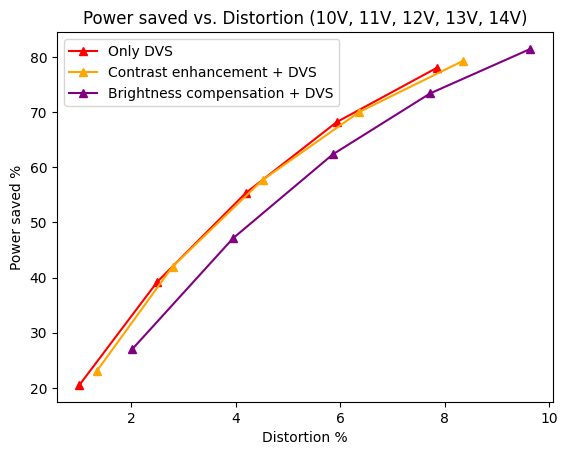

In [ ]:
mean_dvs = func.Distortion_list()
mean_enha = func.Distortion_list()
mean_comp = func.Distortion_list()
for i,item in enumerate(scaling_v):
    mean_dvs.list.append([statistics.mean(dvs_scaling[i][0].distortion_list()),statistics.mean(dvs_scaling[i][0].power_list())])
    mean_enha.list.append([statistics.mean(dvs_scaling[i][1].distortion_list()),statistics.mean(dvs_scaling[i][1].power_list())])
    mean_comp.list.append([statistics.mean(dvs_scaling[i][2].distortion_list()),statistics.mean(dvs_scaling[i][2].power_list())])

plt.plot(mean_dvs.distortion_list(), mean_dvs.power_list(), label='Only DVS', marker='^', color='red')
plt.plot(mean_enha.distortion_list(), mean_enha.power_list(), label='Contrast enhancement + DVS', marker='^', color='orange')
plt.plot(mean_comp.distortion_list(), mean_comp.power_list(), label='Brightness compensation + DVS', marker='^', color='purple')

plt.xlabel('Distortion %')
plt.ylabel('Power saved %')
plt.title(f'Power saved vs. Distortion (10V, 11V, 12V, 13V, 14V)')
plt.legend()
plt.show()



In [83]:
print(len(dvs_scaling[4][1].distortion_list()))
pareto_contrast = func.min_max(dvs_scaling[4][1].distortion_list(), dvs_scaling[4][1].power_list())
pareto_brightness = func.min_max(dvs_scaling[4][1].distortion_list(), dvs_scaling[4][1].power_list())

200
166
108
166
15
166
108
166
15


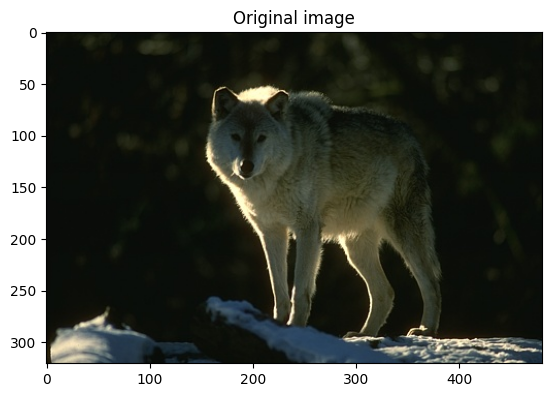

KeyboardInterrupt: 

In [ ]:
#print final image trasformation
scaling_v = [14, 13, 12, 11, 10]

image = func.DATASET[pareto_brightness.min_distortion_index]
obj_image = Image.open(os.path.join(func.DATASET_PATH, image))
image_array = np.array(obj_image)

plt.imshow(image_array)
plt.title('Original image')
plt.show()
for v_new in scaling_v:
    #contrast enhancement
    image_to_process = func.V_scale_b(image_array, v_new/15)

    #image_to_process = image_array #brightness compensation
    #image_to_process = func.V_sum_b(image_to_process, (v_new-15)/15)

    image_to_process = (image_to_process*255).astype(np.uint8)

    height, width, channels = image_to_process.shape
    i_vett = np.array([func.compute_pixel_current(pixel) for row in image_to_process for pixel in row])

    # Reshape back to (height, width, 3)
    i_vett = i_vett.reshape(height, width, channels)

    original, distorted, power = func.displayed_image(i_vett, v_new)
    enha_power = func.compute_panel_power_diff(image_array, 15, distorted, v_new)
    distortion = func.compute_distortion(image_array, distorted)
    dvs_scaling[i][1].list.append([distortion, enha_power])


    #print(f"distortion = {func.compute_distortion(image_array, distorted)}%")

    # plt.imshow(image_array)
    # plt.title('Original image')
    # plt.show()
    plt.imshow(distorted)
    plt.title(f'Constrast enhancement + DVS ({v_new} V)')
    plt.show()

    print(f"power gain = {power}% - distortion = {distortion}% ")
